### In this notebook, I try to add stellar mass and redshift into $\vec{\theta}$, plus noise into the data and forward models

try to write this notebook in a more streamline way

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)
# speculator._build_params_prior()
# speculator.bounds = [speculator.prior[key] for key in speculator.params_name]
# speculator.network.eval();

noise = None # 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

['tage', 'logtau', 'logzsol', 'dust2', 'log M*', 'redshift']

In [4]:
def gen_truth(sfh_kwargs, logz_logm_kwargs, 
              dust2_kwargs, redshift_kwargs, 
              nsamples=5000, random_state=None):
    if random_state is not None:
        torch.manual_seed(random_state)
    y_sfh = MultivariateNormal(torch.Tensor(sfh_kwargs['loc']), 
                               covariance_matrix=torch.Tensor(sfh_kwargs['cov'])
                              ).sample(sample_shape=(nsamples,))
    
    y_logz_logm = MultivariateNormal(torch.Tensor(logz_logm_kwargs['loc']), 
                                     torch.Tensor(logz_logm_kwargs['cov'])
                                    ).sample(sample_shape=(nsamples,))
    y_dust2 = torch.normal(mean=dust2_kwargs['mean'], std=dust2_kwargs['std'], size=(nsamples, 1))
    y_redshift = torch.normal(mean=redshift_kwargs['mean'], std=redshift_kwargs['std'], size=(nsamples, 1))
    
    Y_truth = torch.hstack([y_sfh, y_logz_logm[:, 0:1], y_dust2, y_logz_logm[:, 1:], y_redshift]).to('cuda')
    return Y_truth

In [5]:
sfh_kwargs = {'loc': [6, 0], 'cov': [[1, 0], [0, 1]]}
logz_logm_kwargs = {'loc': [-0.5, 10.5], 
                    'cov': [[0.3, 0.2], 
                            [0.4, 0.6]]}
dust2_kwargs = {'mean': 1, 'std': 0.5}
redshift_kwargs = {'mean': 0.15, 'std': 0.03}

In [6]:
Y_truth = gen_truth(sfh_kwargs, logz_logm_kwargs, 
                    dust2_kwargs, redshift_kwargs,
                    nsamples=5000, random_state=None)

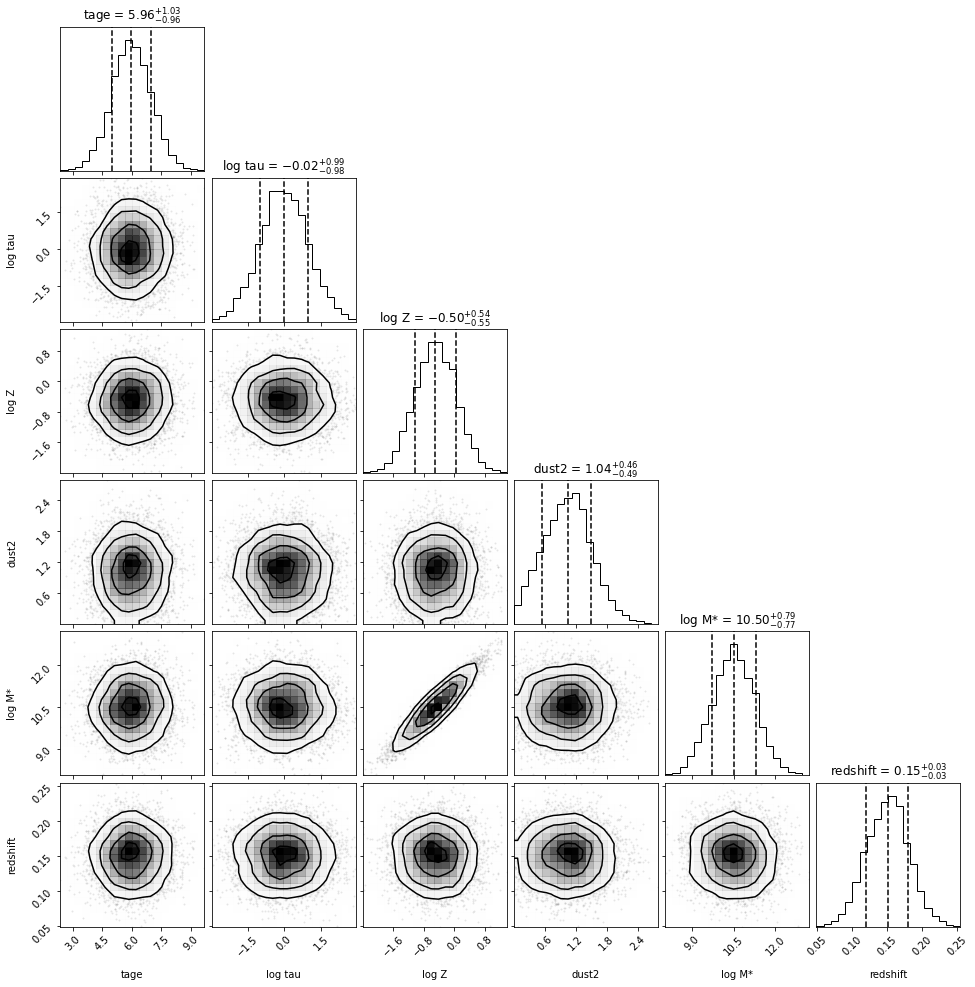

In [10]:
X_data = speculator._predict_mag_with_mass_redshift(
    Y_truth,
    filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
    noise=noise, 
    noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

# _X_data_clean = speculator.predict_mag(y_data, 
#                                 log_stellar_mass=y_stellar_mass, 
#                                 redshift=y_redshift,
#                                 filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
#                                 noise=None,
#                                ).cpu().detach().numpy()
# _X_data_clean = Tensor(_X_data_clean).to('cuda')
# _X_data_clean = _X_data_clean[~torch.isnan(_X_data_clean).any(dim=1)]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [12]:
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.2)

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [48]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss
#del NDE_theta, samples

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=5, # 10, 
                                              num_bins=20, 
                                              hidden_features=50, # 120, 
                                              output_dir=None, 
#                                               initial_pos={'mean': [6, 3, 10.0, 0.05], 'std': [1, 1, 1, 0.05]},
                                              initial_pos={'mean': [5, 0, -0.5, 1.5, 10, 0.15], 
                                                           'std':  [1, 1, 0.3, 0.3, 1, 0.02], 
                                                           'perturb': [0.3, 0.3, 0.3, 0.3, 0.4, 0.005]
                                                          },
#                                               initial_pos={'mean': [5, 0, -0.5, 1.5, 10, 0.15], 
#                                                            'std':  np.array([1, 1, 0.1, 0.3, 1, 0.02]) / 5},
                                              normalize=False)
NDE_theta.build(
    Y_train,
    X_train,
    optimizer='adam')

NDE_theta.load_validation_data(X_vali, Y_vali)

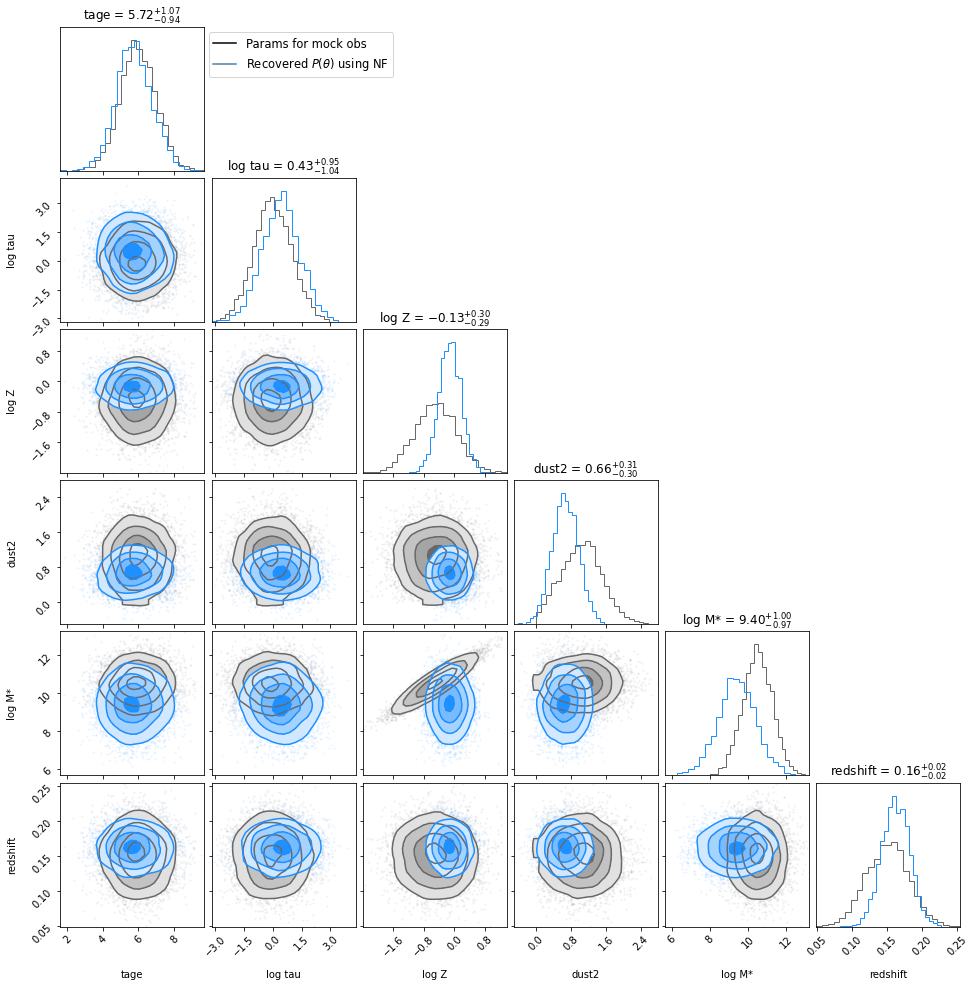

In [49]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [50]:
max_epochs = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100, n_samples=5000,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 1, 'blur': 0.1, 'scaling': 0.8},
                    scheduler=scheduler
                   )
    #scheduler.step()

lr: 3.9999999999999996e-05


Loss = 0.220 (train), 0.249 (vali), 0.031 (bad ratio): 100%|██████████████████████████| 100/100 [00:48<00:00,  2.07epochs/s]


lr: 0.0007658192103303784


Loss = 0.162 (train), 0.234 (vali), 0.032 (bad ratio): 100%|██████████████████████████| 100/100 [00:47<00:00,  2.10epochs/s]


lr: 0.0009485192531172955


Loss = 0.158 (train), 0.252 (vali), 0.032 (bad ratio): 100%|██████████████████████████| 100/100 [00:47<00:00,  2.11epochs/s]


lr: 0.0006068821499737472


Loss = 0.135 (train), 0.204 (vali), 0.027 (bad ratio): 100%|██████████████████████████| 100/100 [00:47<00:00,  2.11epochs/s]


lr: 0.00018476211394223113


Loss = 0.151 (train), 0.197 (vali), 0.031 (bad ratio): 100%|██████████████████████████| 100/100 [00:47<00:00,  2.11epochs/s]


In [58]:
max_epochs = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-4, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)
NDE_theta.train(n_epochs=100, n_samples=5000,
                speculator=speculator, 
                noise=noise, noise_model_dir=noise_model_dir,
                sinkhorn_kwargs={'p': 2, 'blur': 0.1, 'scaling': 0.8},
                scheduler=scheduler
               )

Loss = 0.145 (train), 0.137 (vali), 0.032 (bad ratio): 100%|██████████████████████████| 100/100 [00:47<00:00,  2.12epochs/s]


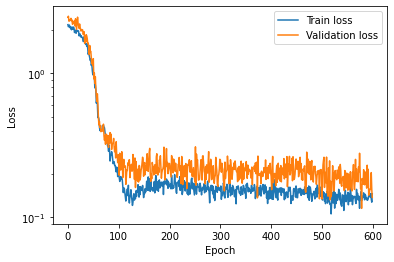

In [59]:
NDE_theta.plot_loss()
plt.yscale('log')

In [29]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(2000))
)
# bad_ratio = (torch.isnan(Y).any(dim=1).sum() +
#              torch.isinf(Y).any(dim=1).sum()) / len(Y)
# val = 20.0
# Y = torch.nan_to_num(Y, val, posinf=val, neginf=-val)
# Y = Y[~(torch.isinf(Y).any(dim=1) | torch.isnan(Y).any(dim=1))]
# Y = torch.nan_to_num(Y, 0.0, posinf=0.0, neginf=-.0)

In [30]:
torch.isnan(Y).any(dim=1).sum()

tensor(1, device='cuda:0')

In [31]:
NDE_theta.sample(2000)

tensor([[ 5.7489,  1.2815, -1.2088,  1.1225, 10.7241,  0.0735],
        [ 5.8644, -1.5252, -0.4302,  1.5011, 10.3456,  0.0977],
        [ 5.9768,  0.9022, -1.0488,  1.4506, 10.4759,  0.0709],
        ...,
        [ 6.6109,  0.2610, -0.5249,  2.1682, 10.7690,  0.0723],
        [ 6.4257,  1.1549, -0.2973,  1.4553, 10.0350,  0.0776],
        [ 5.0846,  0.0448, -0.7546,  1.4957, 10.8392,  0.1045]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [32]:
torch.isnan(Y).any(dim=1).sum()

tensor(1, device='cuda:0')

In [39]:
Y

tensor([[ 1.3807,  1.1714,  0.8468,  0.6523,  0.4901],
        [    nan,     nan,     nan,     nan,     nan],
        [-0.0575,  0.2691,  0.3022,  0.3346,  0.3498],
        ...,
        [-1.0246, -0.8114, -0.8066, -0.7873, -0.7704],
        [-0.6809, -0.5143, -0.5775, -0.6075, -0.6391],
        [ 0.7138,  0.6469,  0.4885,  0.4343,  0.4061]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [243]:
NDE_theta.train_loss_history[np.argmin(NDE_theta.vali_loss_history)]

0.024843484163284302

In [60]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

Best epoch: 0
Best train loss: 0.14529001712799072
Best vali loss: 0.13721191883087158


In [61]:
NDE_theta.goodness_of_fit(Y_truth, p=1)

Log10 Wasserstein distance in theta space:  -0.08726260440198791


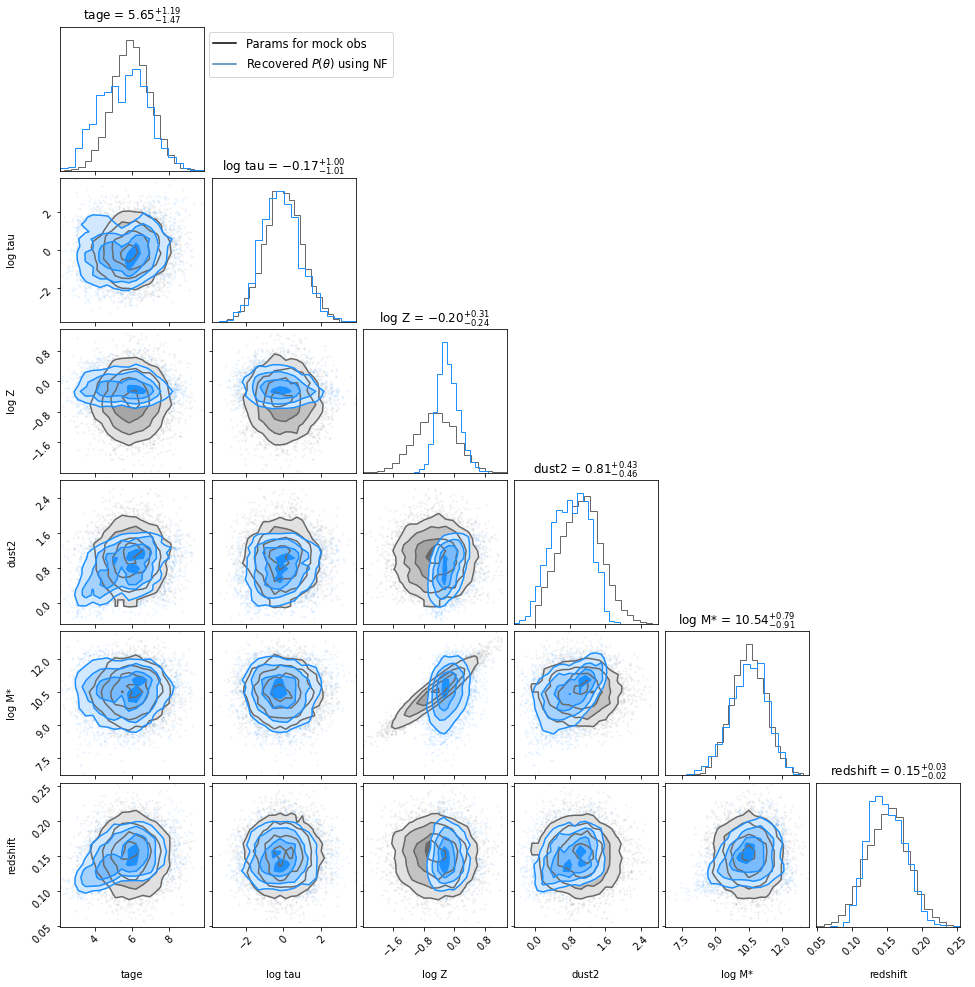

In [62]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=20,
                       #range=[[2.0, 10.0], [-3, 4], [-2, 1], [0, 4], [8, 12], [-0.05, 0.2]],
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

samples = torch.nan_to_num(samples, 0, posinf=0, neginf=0)
nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=20,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('With noise')

159 5000


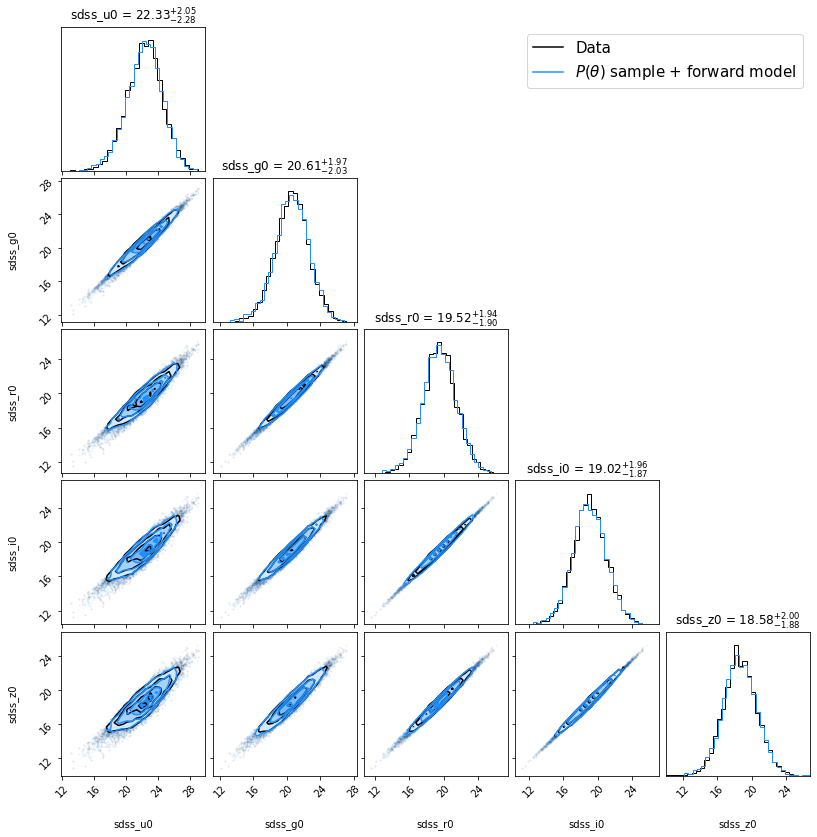

In [63]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [15]:
from geomloss import SamplesLoss

In [48]:
Y = speculator._predict_mag_with_mass_redshift(samples,
                                               noise=noise,
                                               noise_model_dir=noise_model_dir,
                                                  )
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

In [47]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(3996))
)
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

In [21]:
with open('./umap_mags.pkl', 'rb') as f:
    reducer = pickle.load(f)

In [68]:
embedding_Y = reducer.transform(Y.cpu().detach().numpy())
embedding_X = reducer.transform(X_train.cpu().detach().numpy())

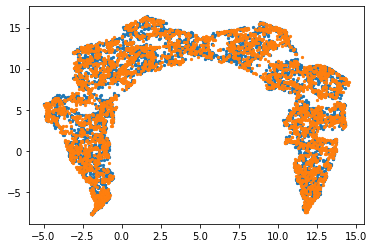

In [70]:
plt.scatter(embedding_Y[:, 0], embedding_Y[:, 1], s=5)
plt.scatter(embedding_X[:, 0], embedding_X[:, 1], s=5)

In [45]:
L = SamplesLoss(loss="sinkhorn", p=1, scaling=0.5, blur=0.01)

In [49]:
L(X_train, Y)

tensor(0.2975, device='cuda:0', grad_fn=<SelectBackward0>)

In [72]:
L(torch.Tensor(embedding_X), 
  torch.Tensor(embedding_Y))

tensor(0.1284)

In [158]:
torch.log10(L(NDE_theta.X, Y))

tensor(-1.5337, device='cuda:0', grad_fn=<SubBackward0>)

### Fuzzy logic?
$y = \log\left(\frac{1}{1 + |x / a|^{2b}}\right)$